In [1]:
from test_denoiser import test_acc, evaluate_metrics, img_to_numpy, generate_attack
from adversarial_dataset import get_dataloader
from models.denoisers import DnCNN, ConvDAE
from load_model import load_resnet
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#mnist
#dncnn
mnist_denoiser1 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
mnist_denoiser1.load_state_dict(torch.load('./trained_denoisers/dncnn_mnist_mixed+gaussian.pth', map_location=device))
#dae denoiser
mnist_denoiser2 = ConvDAE(in_channels=3, out_channels=3, num_layers=5, use_bias=False).to(device)
mnist_denoiser2.load_state_dict(torch.load('./trained_denoisers/dae_mnist_mixed+gaussian.pth', map_location=device))

#cifar10
#dncnn
cifar10_denoiser1 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_denoiser1.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed+gaussian.pth', map_location=device))
cifar10_denoiser2 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_denoiser2.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed.pth', map_location=device))
cifar10_denoiser3 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=False).to(device)
cifar10_denoiser3.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_gaussian.pth', map_location=device))
#dae
cifar10_denoiser4 = ConvDAE(in_channels=3, out_channels=3, num_layers=5, use_bias=False).to(device)
cifar10_denoiser4.load_state_dict(torch.load('./trained_denoisers/dae_cifar10_mixed+gaussian.pth', map_location=device))
# #dncnn bias
# cifar10_denoiser5 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bias=True).to(device)
# cifar10_denoiser5.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed+gaussian_bias.pth', map_location=device))
# #dncnn no batchnorm
# cifar10_denoiser6 = DnCNN(in_channels=3, out_channels=3, depth=7, hidden_channels=64, use_bn=False, use_bias=False).to(device)
# cifar10_denoiser6.load_state_dict(torch.load('./trained_denoisers/dncnn_cifar10_mixed+gaussian_nobn.pth', map_location=device))

<All keys matched successfully>

In [32]:
from matplotlib.ticker import FormatStrFormatter
# ================== Save/load result ================= #
def save_result(filename, result, root='denoiser_attack_results', overwrite=False):
    if not os.path.exists(root): os.mkdir(root)

    file_path = os.path.join(root, filename)
    if os.path.exists(file_path) and (not overwrite):
        print("Updating pickle file")
        prev_result = load_result(file_path)
        prev_result.update(result)
        result = prev_result
        
    with open(file_path, 'wb') as f:
        pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_result(file_path):
    if not os.path.exists(file_path):
        raise ValueError("Results file not found.")
    
    with open(file_path, "rb") as f:
        result = pickle.load(f)
    
    return result


def load_model_data(dataset, batch_size=64):
    print(batch_size)
    #vanilla resnet model
    if dataset == 'mnist':
        resnet = load_resnet(device=device, grayscale=True)
        resnet.load_state_dict(torch.load('./trained_models/mnist/resnet18_2.0+0_BL.pth', map_location=device))
        #dataset loader
        train_loader, test_loader = get_dataloader(dataset='mnist', batch_size=batch_size, sample_test=True)
    elif dataset == 'cifar10':
        resnet = load_resnet(device=device, grayscale=False)
        resnet.load_state_dict(torch.load('./trained_models/cifar10/resnet18_2.0+0_BL_plot.pth', map_location=device))

        train_loader, test_loader = get_dataloader(dataset='cifar10', batch_size=batch_size, sample_test=True)

    print(len(train_loader.dataset))
    print(len(test_loader.dataset))

    return resnet, train_loader, test_loader


def unpack_dict(result_dict):
    acc_list = []
    for key in result_dict:
        acc = result_dict[key]
        acc_list.append(acc)
    return acc_list


# =================== Attacking ===================== #
def run_attack(test_loader, net, denoisers, attack_mode, eps_range, norm):
    #initialize result
    result = {}
    result['adv'] = []
    for i in range(len(denoisers)):
        result[f'dn{i+1}'] = []
        
    for eps in eps_range:
        print("eps = ", eps)
        accuracies = test_acc(net, denoisers, test_loader, attack_mode, norm, eps)
        result['adv'].append(accuracies[1])
        for i in range(len(denoisers)):
            result[f'dn{i+1}'].append(accuracies[i+2])

    return result    


def run_denoiser_exp(dataset, denoisers, attacks=['fgsm', 'pgd', 'cw']):

    print(f"Running experiment on {dataset} ...")
    # load pretrained resnet and data
    net, _, test_loader = load_model_data(dataset)
    #l2 attack eps
    l2_eps = [0.5, 1.0, 2.0, 3.5]
    #linf attack eps
    linf_eps = [x/256 for x in [2, 5, 10, 16]]

    # run attack
    for attack in attacks:
        if attack == 'cw':
            print(f"\nEvaluating {attack} attack ...")
            file_name = f"{dataset}_{attack}.pkl"
            # l2 norm cw attack
            result = run_attack(test_loader, net, denoisers, attack, l2_eps, norm=2)
            save_result(file_name, result, overwrite=True)
        else:
            # linf norm for fgsm and pgd
            for norm in [np.inf]:
                print(f"\nEvaluating {attack} attack on l{norm} norm ...")
                file_name = f"{dataset}_{attack}_l{str(norm)}.pkl"
                # get eps range
                eps_range = l2_eps if norm == 2 else linf_eps
                
                result = run_attack(test_loader, net, denoisers, attack, eps_range, norm=norm)
                save_result(file_name, result, overwrite=True)


# ================ Plotting ================= #
def plot_mnist_result(result, attack, norm, eps_range, ax, savefig=True, denoised2=True):

    acc_list = unpack_dict(result)
    sns.set_theme(style="darkgrid")
    #plt.figure(figsize=(5,5), dpi=200)
    ax.plot(eps_range, acc_list[0], marker='o', linewidth=1.5, markersize=3, label="No Denoiser")
    ax.plot(eps_range, acc_list[1], marker='o', linewidth=1.5, markersize=3, label="DnCNN - mixed")
        
    if denoised2:
        ax.plot(eps_range, acc_list[2], marker='o', linewidth=1.5, markersize=3, label="AutoEncoder - mixed")

    ax.legend(loc="lower left", fontsize=8)
    ax.set_xlabel('epsilon')
    ax.set_ylabel('model accuracy')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title(f"MNIST {attack.upper()} attack (L{norm})")
    if savefig:
        if not os.path.exists('denoiser_attack_figures'): os.mkdir('denoiser_attack_figures')
        fig_name = f"mnist_{attack}_l{norm}.png"
        plt.savefig(os.path.join('denoiser_attack_figures', fig_name), dpi=200)

    #plt.show()


def plot_cifar10_result(result, attack, norm, eps_range, ax, savefig=True):

    acc_list = unpack_dict(result)
    sns.set_theme(style="darkgrid")
    #plt.figure(figsize=(5,5), dpi=200)
    ax.plot(eps_range, acc_list[0], marker='o', linewidth=1.5, markersize=3, label="No Denoiser")
    ax.plot(eps_range, acc_list[1], marker='o', linewidth=1.5, markersize=3, label="DnCNN - fgsm+pgd+gaussian")
    ax.plot(eps_range, acc_list[2], marker='o', linewidth=1.5, markersize=3, label="DnCNN - fgsm+pgd")
    ax.plot(eps_range, acc_list[3], marker='o', linewidth=1.5, markersize=3, label="DnCNN - gaussian")
    ax.plot(eps_range, acc_list[4], marker='o', linewidth=1.5, markersize=3, label="AutoEncoder - fgsm+pgd+gaussian")

    ax.legend(loc="upper right", fontsize=8)
    ax.set_xlabel('epsilon')
    ax.set_ylabel('model accuracy')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title(f"CIFAR-10 {attack.upper()} attack (L{norm})")
    if savefig:
        if not os.path.exists('denoiser_attack_figures'): os.mkdir('denoiser_attack_figures')
        fig_name = f"cifar10_{attack}_l{norm}.png"
        plt.savefig(os.path.join('denoiser_attack_figures', fig_name), dpi=200)

    #plt.show()


def show_comparison(model, denoisers, test_loader, attack, norm, eps, show_idx):
    images, _ = next(iter(test_loader))
    # original
    images = images.to(device)
    n = len(denoisers)
    # adversarial
    x_adv = generate_attack(images, model, attack, norm, eps)
    denoised = [0 for _ in range(n)]
    # denoised
    for i, denoiser in enumerate(denoisers):   
        denoiser.eval()
        denoised[i] = denoiser(x_adv)
    
    #plt.figure(figsize=(5, 3))
    plt.figure(figsize=(10, 6))
    # display original
    ax = plt.subplot(2, 4, 2)
    plt.imshow(img_to_numpy(images[show_idx]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)     
    # display noisy
    ax = plt.subplot(2, 4, 3)
    img = img_to_numpy(x_adv[show_idx])
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.figtext(0.375,0.95, "Original", ha="center", va="center", fontsize=15, color="b")
    plt.figtext(0.625,0.95, f"Perturbed ({attack})", ha="center", va="center", fontsize=15, color="r")
    # plt.tight_layout()
    # plt.savefig(os.path.join('denoiser_attack_figures', f'{attack}_orig_adv.png'), dpi=300)
    # plt.show()

    #plt.figure(figsize=(10, 3))
    for i in range(n):
        # display denoised image
        ax = plt.subplot(2, n, n+i+1)
        img = img_to_numpy(denoised[i][show_idx])
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.125,0.5, "DnCNN (f+p+g)", ha="center", va="center", fontsize=15)
    plt.figtext(0.375,0.5, "DnCNN (f+p)", ha="center", va="center", fontsize=15)
    plt.figtext(0.625,0.5, "DnCNN (g)", ha="center", va="center", fontsize=15)
    plt.figtext(0.875,0.5, "ConvDAE (f+p+g)", ha="center", va="center", fontsize=15)
    plt.tight_layout()
    #plt.savefig(os.path.join('denoiser_attack_figures', f'{attack}_denoiser_comp.png'), dpi=300)
    plt.savefig(os.path.join('denoiser_attack_figures', f'{attack}_denoiser_comp2.png'), dpi=300)
    plt.show()


def show_random_batch(model, denoiser, test_loader, attack, norm, eps, n=5, eval=False):
    denoiser.eval()
    images, _ = next(iter(test_loader))
    # original
    images = images.to(device)
    # adversarial
    x_adv = generate_attack(images, model, attack, norm, eps)
    # denoised
    denoised = denoiser(x_adv)

    plt.figure(figsize=(5, 4.5), dpi=200)
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(img_to_numpy(images[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(3, n, i+1 + n)
        img = img_to_numpy(x_adv[i])
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display denoised image
        ax = plt.subplot(3, n, i+1 + n + n)
        img = img_to_numpy(denoised[i])
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "Original Images", ha="center", va="center", fontsize=10, color="b")
    plt.figtext(0.5,0.65, f"Adversarial Images ({attack})", ha="center", va="center", fontsize=10, color="r")
    plt.figtext(0.5,0.33, "Denoised Images", ha="center", va="center", fontsize=10, color="g")
    if eval:
        avg_psnr_bl, avg_ssim_bl, avg_psnr, avg_ssim, total = evaluate_metrics(model, denoiser, test_loader, attack, norm, eps)
        plt.figtext(0.5,0.38, "PSNR: {:.3f}dB, SSIM: {:.3f} (averaged over {} images)".format(avg_psnr_bl, avg_ssim_bl, total), ha="center", va="center", fontsize=10)
        plt.figtext(0.5,0.08, "PSNR: {:.3f}dB, SSIM: {:.3f} (averaged over {} images)".format(avg_psnr, avg_ssim, total), ha="center", va="center", fontsize=10)
    plt.subplots_adjust(hspace = 0.1)    
    plt.tight_layout()
    plt.savefig(os.path.join('denoiser_attack_figures', f'{attack}_samples.png'), dpi=300)
    plt.show()


In [ ]:
# run mnist
mnist_denoisers = [mnist_denoiser1, mnist_denoiser2]
run_denoiser_exp(dataset='mnist', denoisers=mnist_denoisers)

In [ ]:
# run cifar10
cifar10_denoisers = [cifar10_denoiser1, cifar10_denoiser2, cifar10_denoiser3, cifar10_denoiser4]
run_denoiser_exp(dataset='cifar10', denoisers=cifar10_denoisers)

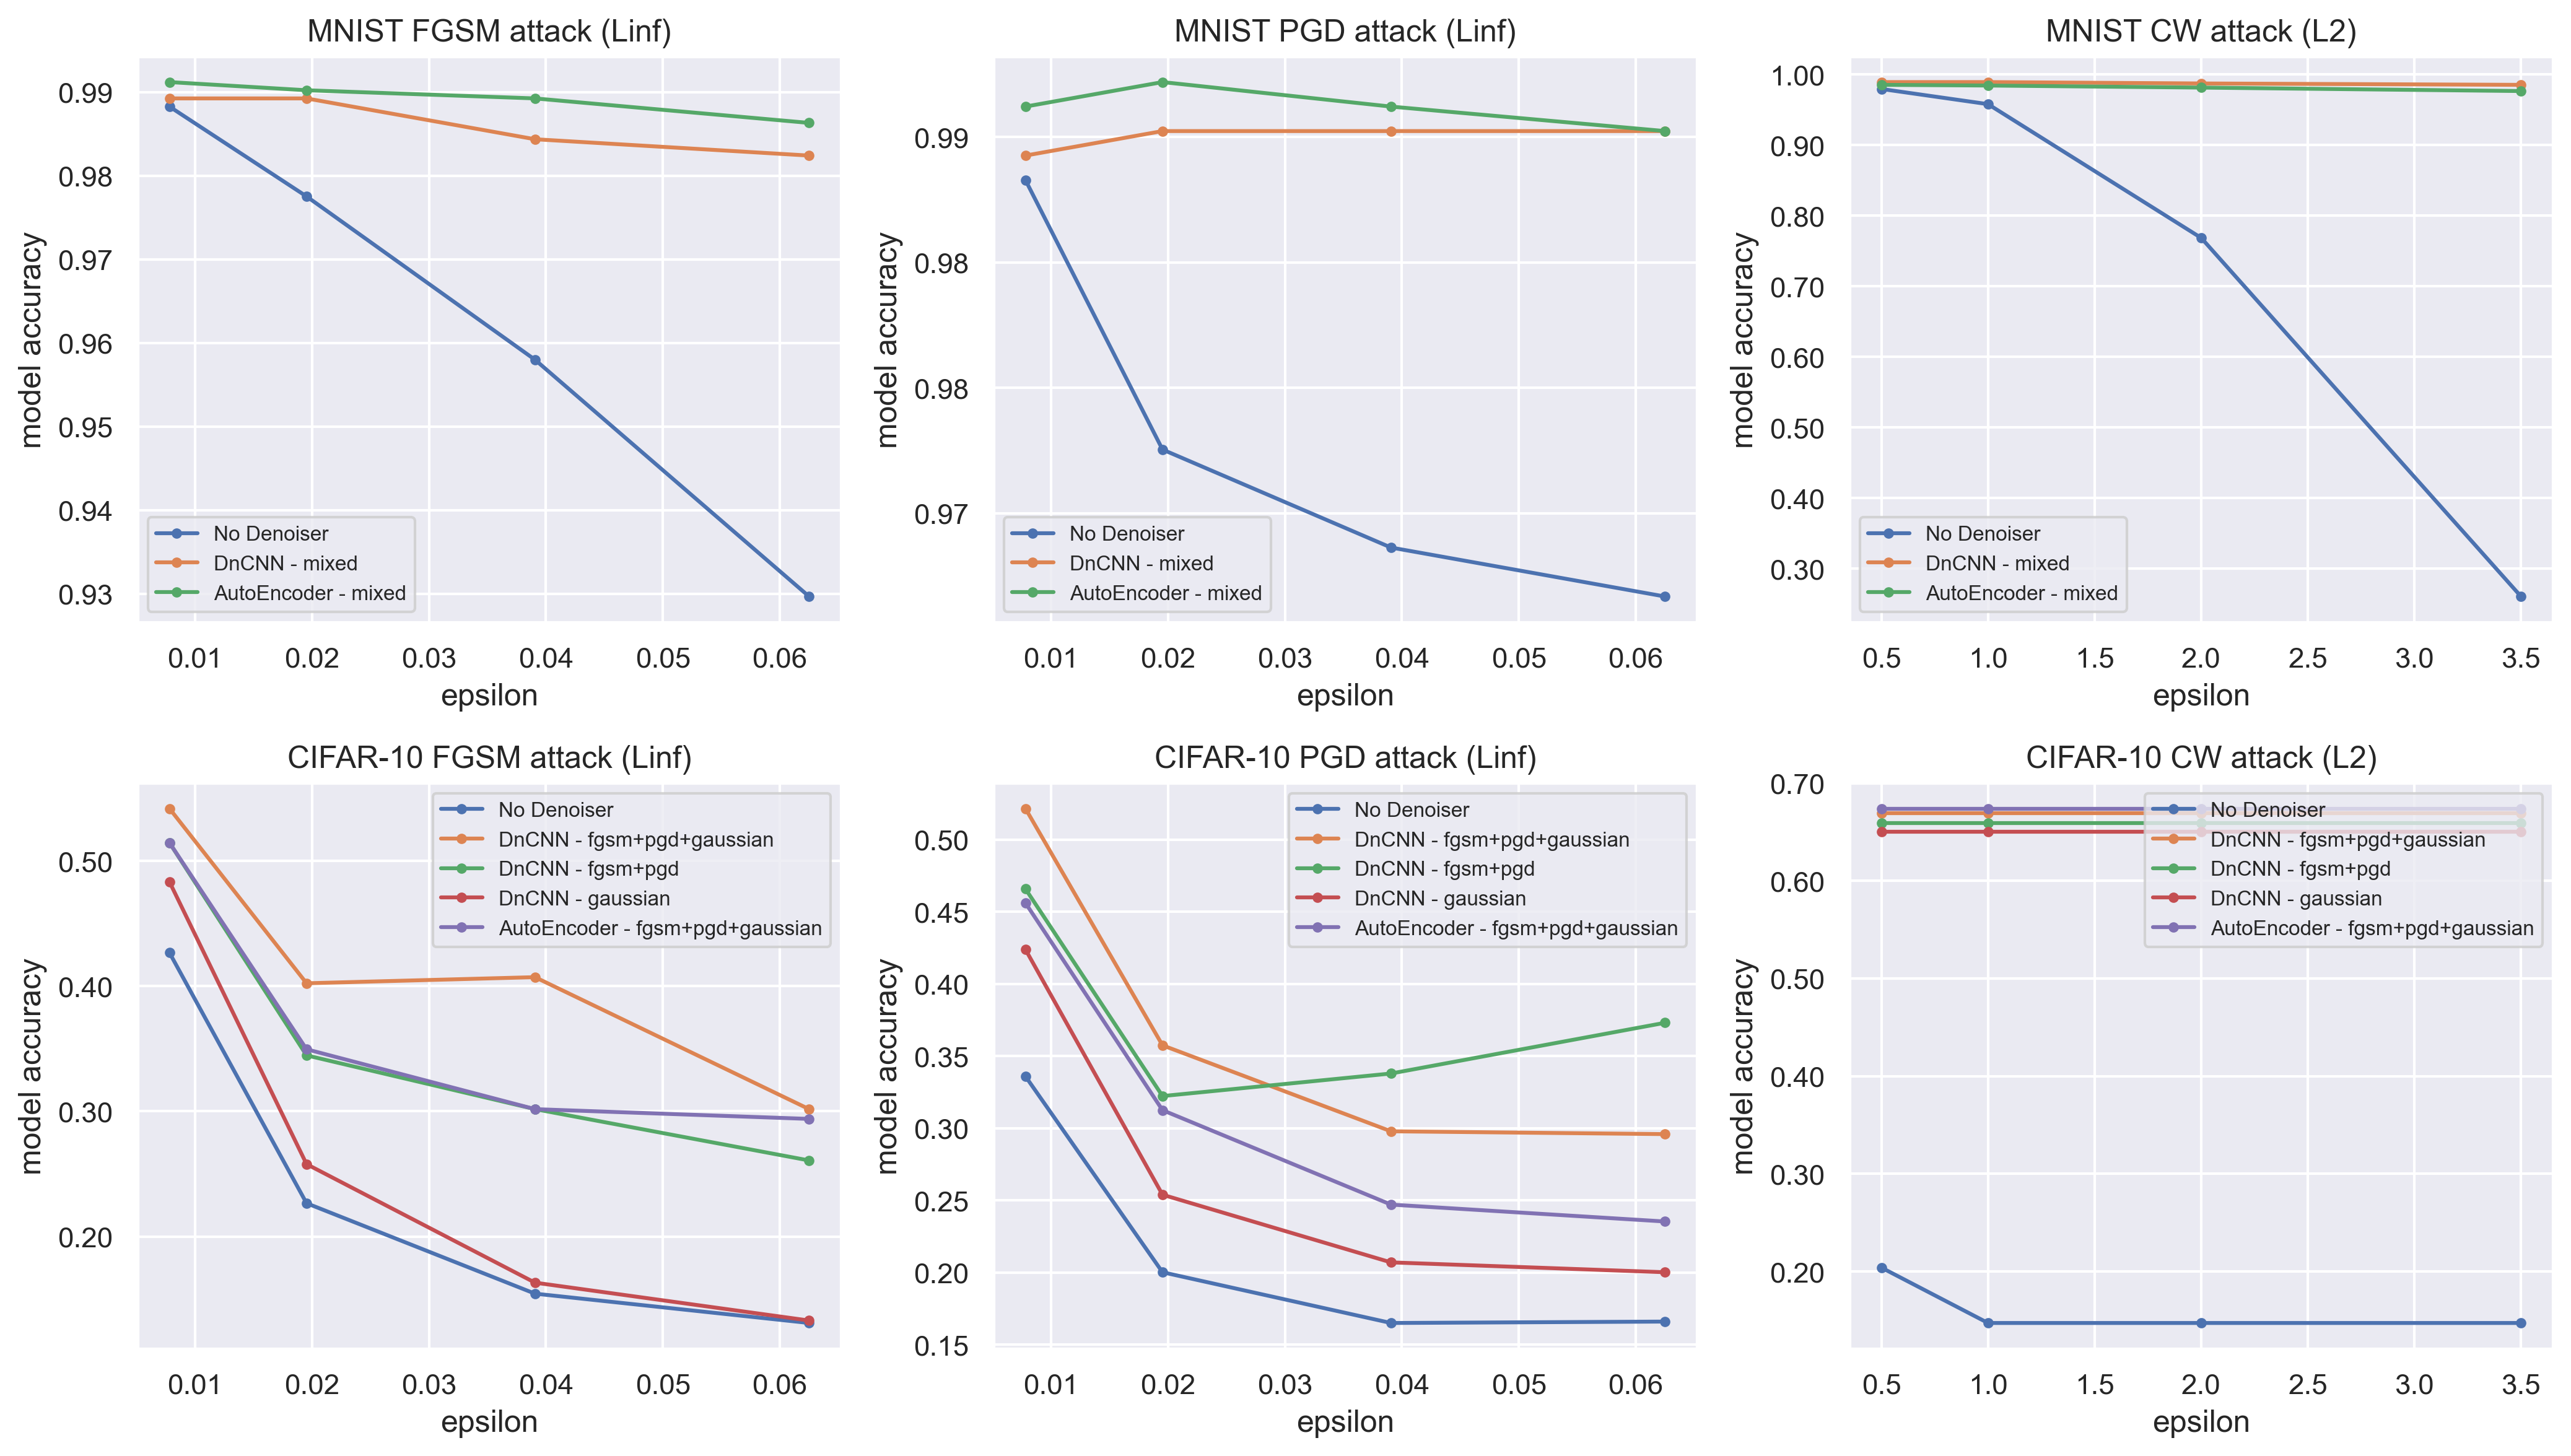

In [33]:
#plot mnist
# plt.figure(figsize=(12, 4), dpi=200)
# for i, attack in enumerate(['fgsm', 'pgd', 'cw']):
#     ax = plt.subplot(1, 3, i+1)
#     eps_range=[0.5, 1.0, 2.0, 3.5] if attack == 'cw' else [x/256 for x in [2, 5, 10, 16]]
#     norm='2' if attack == 'cw' else 'inf'
#     file_name =f"mnist_{attack}.pkl" if attack == 'cw' else f"mnist_{attack}_linf.pkl"
#     file_path = os.path.join('denoiser_attack_results', file_name)
#     result = load_result(file_path)
#     plot_mnist_result(result, attack, norm, eps_range, ax, savefig=True)

# plt.tight_layout()
# plt.show()
plt.figure(figsize=(14,8), dpi=300)

for i, attack in enumerate(['fgsm', 'pgd', 'cw']):
    #plt.figure(figsize=(5,4), dpi=200)
    #plt.tight_layout()
    #ax = plt.axes()
    ax = plt.subplot(2, 3, i+1)

    if attack == 'cw':
        file_path = os.path.join('denoiser_attack_results', f"mnist_{attack}.pkl")
        result = load_result(file_path)
        plot_mnist_result(result, attack, '2', [0.5, 1.0, 2.0, 3.5], ax, savefig=True)
    else:
        file_path = os.path.join('denoiser_attack_results', f"mnist_{attack}_linf.pkl")
        result = load_result(file_path)
        plot_mnist_result(result, attack, 'inf', [x/256 for x in [2, 5, 10, 16]], ax, savefig=True)

    
    ax = plt.subplot(2, 3, 3+i+1)

    if attack == 'cw':
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}.pkl")
        result = load_result(file_path)
        plot_cifar10_result(result, attack, '2', [0.5, 1.0, 2.0, 3.5], ax, savefig=True)
    else:
        #print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}_linf.pkl")
        result = load_result(file_path)
        plot_cifar10_result(result, attack, 'inf', [x/256 for x in [2, 5, 10, 16]], ax, savefig=True)

plt.tight_layout()
plt.show()

In [ ]:
#plot cifar10
# plt.figure(figsize=(15, 5), dpi=200)
# for i, attack in enumerate(['fgsm', 'pgd', 'cw']):
#     ax = plt.subplot(1, 3, i+1)
#     eps_range=[0.5, 1.0, 2.0, 3.5] if attack == 'cw' else [x/256 for x in [2, 5, 10, 16]]
#     norm='2' if attack == 'cw' else 'inf'
#     file_name =f"cifar10_{attack}.pkl" if attack == 'cw' else f"cifar10_{attack}_linf.pkl"
#     file_path = os.path.join('denoiser_attack_results', file_name)
#     result = load_result(file_path)
#     plot_cifar10_result(result, attack, norm, eps_range, ax, savefig=True)
    
# plt.tight_layout()
# plt.show()

for i, attack in enumerate(['fgsm', 'pgd', 'cw']):
    plt.figure(figsize=(5,4), dpi=200)
    plt.tight_layout()
    ax = plt.axes()

    if attack == 'cw':
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}.pkl")
        result = load_result(file_path)
        plot_cifar10_result(result, attack, '2', [0.5, 1.0, 2.0, 3.5], ax, savefig=True)
    else:
        #print(f"\nEvaluating {attack} attack on l{norm} norm ...")
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}_linf.pkl")
        result = load_result(file_path)
        plot_cifar10_result(result, attack, 'inf', [x/256 for x in [2, 5, 10, 16]], ax, savefig=True)
    
    plt.show()

In [ ]:
#plot pairs
for i, attack in enumerate(['fgsm', 'pgd', 'cw']):
    plt.figure(figsize=(10,4), dpi=200)
    plt.tight_layout()
    
    if attack == 'cw':
        file_path1 = os.path.join('denoiser_attack_results', f"mnist_{attack}.pkl")
        file_path2 = os.path.join('denoiser_attack_results', f"cifar10_{attack}.pkl")
        norm = '2'
        eps_range = [0.5, 1.0, 2.0, 3.5]
    else:
        file_path1 = os.path.join('denoiser_attack_results', f"mnist_{attack}_linf.pkl")
        file_path2 = os.path.join('denoiser_attack_results', f"cifar10_{attack}_linf.pkl")
        norm = 'inf'
        eps_range = [x/256 for x in [2, 5, 10, 16]]
    
    ax = plt.subplot(121)
    result1 = load_result(file_path1)
    plot_mnist_result(result1, attack, norm, eps_range, ax, savefig=True)

    ax = plt.subplot(122)
    result2 = load_result(file_path2)
    plot_cifar10_result(result2, attack, norm, eps_range, ax, savefig=True)

    plt.show()

In [4]:
net, _, test_loader = load_model_data('mnist')
mnist_denoisers = [mnist_denoiser1, mnist_denoiser2]
evaluate_metrics(net, mnist_denoisers, test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
evaluate_metrics(net, mnist_denoisers, test_loader, attack='pgd', norm=np.inf, eps=0.0625)
evaluate_metrics(net, mnist_denoisers, test_loader, attack='cw', norm=2, eps=3.5)

64
60000
1024


100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Baseline: 
Average PSNR:26.771 
Average SSIM: 0.793
Denoiser1: (Average PSNR:34.601 , Average SSIM: 0.996)
Denoiser2: (Average PSNR:35.267 , Average SSIM: 0.997)


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


Baseline: 
Average PSNR:30.751 
Average SSIM: 0.855
Denoiser1: (Average PSNR:36.024 , Average SSIM: 0.983)
Denoiser2: (Average PSNR:37.122 , Average SSIM: 0.998)


100%|██████████| 16/16 [05:01<00:00, 18.84s/it]

Baseline: 
Average PSNR:inf 
Average SSIM: 0.990
Denoiser1: (Average PSNR:39.795 , Average SSIM: 0.991)
Denoiser2: (Average PSNR:43.267 , Average SSIM: 0.991)


(1024,
 inf,
 0.9903284552274272,
 [{'PSNR': 39.794874269470505, 'SSIM': 0.9912850750260986},
  {'PSNR': 43.267404155700014, 'SSIM': 0.9909774324041791}])

In [3]:
net, _, test_loader = load_model_data('cifar10')
cifar10_denoisers = [cifar10_denoiser1, cifar10_denoiser2, cifar10_denoiser3, cifar10_denoiser4]
evaluate_metrics(net, cifar10_denoisers, test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
evaluate_metrics(net, cifar10_denoisers, test_loader, attack='pgd', norm=np.inf, eps=0.0625)
evaluate_metrics(net, cifar10_denoisers, test_loader, attack='cw', norm=2, eps=3.5)
# evaluate_metrics(net, cifar10_denoiser1, test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
# evaluate_metrics(net, cifar10_denoiser2, test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
# evaluate_metrics(net, cifar10_denoiser3, test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
# evaluate_metrics(net, cifar10_denoiser4, test_loader, attack='fgsm', norm=np.inf, eps=0.0625)

64
Files already downloaded and verified
Files already downloaded and verified
50000
1024


  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\junbo\Downloads\csc2529_project\test_denoiser.py:95: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  avg_ssim_bl += SSIM(original, adv, multichannel=True)
100%|██████████| 16/16 [00:05<00:00,  2.76it/s]


Baseline: 
Average PSNR:24.208 
Average SSIM: 0.843
Denoiser1: (Average PSNR:31.816 , Average SSIM: 0.974)
Denoiser2: (Average PSNR:30.648 , Average SSIM: 0.965)
Denoiser3: (Average PSNR:25.857 , Average SSIM: 0.888)
Denoiser4: (Average PSNR:31.399 , Average SSIM: 0.971)


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Baseline: 
Average PSNR:28.731 
Average SSIM: 0.932
Denoiser1: (Average PSNR:33.626 , Average SSIM: 0.979)
Denoiser2: (Average PSNR:32.064 , Average SSIM: 0.971)
Denoiser3: (Average PSNR:32.078 , Average SSIM: 0.970)
Denoiser4: (Average PSNR:33.391 , Average SSIM: 0.979)


 75%|███████▌  | 12/16 [03:20<01:09, 17.43s/it]c:\Users\junbo\anaconda3\envs\csc2529\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
100%|██████████| 16/16 [04:32<00:00, 17.03s/it]

Baseline: 
Average PSNR:inf 
Average SSIM: 0.999
Denoiser1: (Average PSNR:39.656 , Average SSIM: 0.994)
Denoiser2: (Average PSNR:39.764 , Average SSIM: 0.994)
Denoiser3: (Average PSNR:36.873 , Average SSIM: 0.987)
Denoiser4: (Average PSNR:44.432 , Average SSIM: 0.998)


(1024,
 inf,
 0.9991129702539183,
 [{'PSNR': 39.65624604958539, 'SSIM': 0.9936113678850234},
  {'PSNR': 39.76396133030557, 'SSIM': 0.9939619354554452},
  {'PSNR': 36.872734146497855, 'SSIM': 0.9867310819681734},
  {'PSNR': 44.43175543244862, 'SSIM': 0.9979378405259922}])

In [ ]:
net, _, test_loader = load_model_data('cifar10')
evaluate_metrics(net, cifar10_denoiser1, test_loader, attack='pgd', norm=np.inf, eps=0.0625)
evaluate_metrics(net, cifar10_denoiser2, test_loader, attack='pgd', norm=np.inf, eps=0.0625)
evaluate_metrics(net, cifar10_denoiser3, test_loader, attack='pgd', norm=np.inf, eps=0.0625)
evaluate_metrics(net, cifar10_denoiser4, test_loader, attack='pgd', norm=np.inf, eps=0.0625)

In [3]:
net, _, test_loader = load_model_data('cifar10')
evaluate_metrics(net, cifar10_denoiser1, test_loader, attack='cw', norm=2, eps=3.5)
evaluate_metrics(net, cifar10_denoiser2, test_loader, attack='cw', norm=2, eps=3.5)
evaluate_metrics(net, cifar10_denoiser3, test_loader, attack='cw', norm=2, eps=3.5)
evaluate_metrics(net, cifar10_denoiser4, test_loader, attack='cw', norm=2, eps=3.5)

64
Files already downloaded and verified
Files already downloaded and verified
50000
1024


  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\junbo\Downloads\csc2529_project\test_denoiser.py:87: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  avg_ssim_bl += SSIM(original, adv, multichannel=True)
c:\Users\junbo\Downloads\csc2529_project\test_denoiser.py:90: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  avg_ssim += SSIM(original, denoised, multichannel=True)
 75%|███████▌  | 12/16 [03:12<01:02, 15.70s/it]c:\Users\junbo\anaconda3\envs\csc2529\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
100%|██████████| 16/16 [04:14<00:00, 15.92s/it]



Average PSNR:39.652 
Average SSIM: 0.994


100%|██████████| 16/16 [04:14<00:00, 15.92s/it]



Average PSNR:39.759 
Average SSIM: 0.994


100%|██████████| 16/16 [04:12<00:00, 15.78s/it]



Average PSNR:36.873 
Average SSIM: 0.987


100%|██████████| 16/16 [04:10<00:00, 15.69s/it]


Average PSNR:44.424 
Average SSIM: 0.998


(inf, 0.9991025739582255, 44.42439528545378, 0.9979346921900287, 1024)

6
Files already downloaded and verified
Files already downloaded and verified
50000
1024


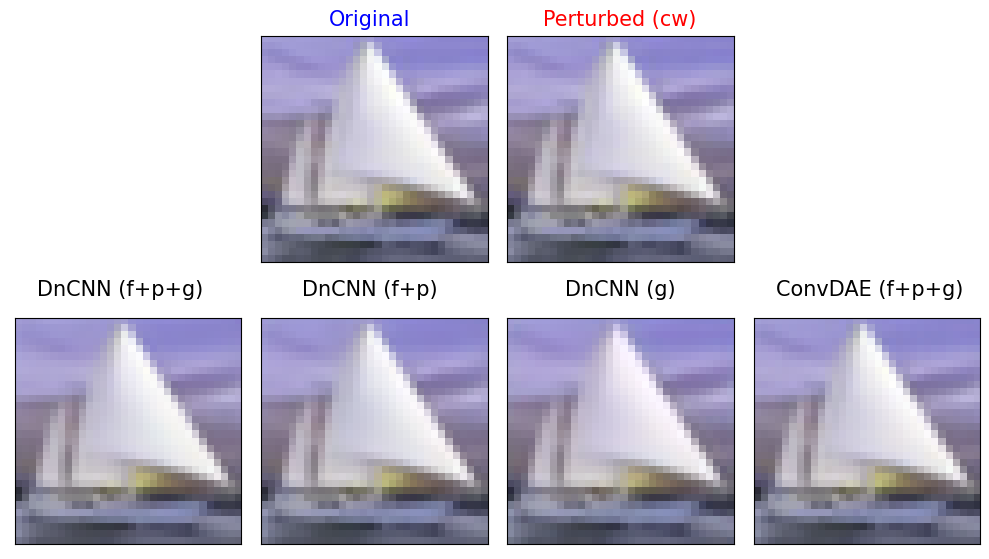

In [17]:
# show_random_batch(mnist_resnet, mnist_denoiser1, mnist_test_loader, attack='fgsm', norm=np.inf, eps=0.0625)
# show_random_batch(net, cifar10_denoiser1, test_loader, attack='fgsm', norm=np.inf, eps=0.0625, eval=True)
# show_random_batch(net, cifar10_denoiser4, test_loader, attack='fgsm', norm=np.inf, eps=0.0625, eval=True)
# show_random_batch(net, cifar10_denoiser1, test_loader, attack='cw', norm=2, eps=3.5, eval=True)
net, _, test_loader = load_model_data('cifar10', batch_size=6)
cifar10_denoisers = [cifar10_denoiser1, cifar10_denoiser2, cifar10_denoiser3, cifar10_denoiser4]
plt.figure()
# show_comparison(net, cifar10_denoisers, test_loader, attack='fgsm', norm=np.inf, eps=0.0625, show_idx=3)
# show_comparison(net, cifar10_denoisers, test_loader, attack='pgd', norm=np.inf, eps=0.0625, show_idx=1)
show_comparison(net, cifar10_denoisers, test_loader, attack='cw', norm=2, eps=3.5, show_idx=4)

In [22]:
for i, attack in enumerate(['fgsm', 'pgd', 'cw']):
    print(attack)
    if attack == 'cw':
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}.pkl")
        result = load_result(file_path)
    else:
        file_path = os.path.join('denoiser_attack_results', f"cifar10_{attack}_linf.pkl")
        result = load_result(file_path)

    acc_list = unpack_dict(result)
    for l in acc_list: print(np.round( 100*np.mean(l), decimals=2))

fgsm
23.46
41.33
35.55
25.93
36.5
pgd
21.68
36.82
37.48
27.12
31.27
cw
16.16
66.89
65.92
65.04
67.38


In [ ]:
import torch
x = torch.ones((4, 4)) / 2
y = torch.ones((2, 3, 4, 4))
yy = torch.randn_like(y[:, 0, :, :].unsqueeze(1))

#print(x)
z = x + y
print(z.size())
#print(z)
print(y.shape[-1])
print(y.shape[-2])
print(yy.shape)
print()
w = torch.empty_like(y[None, :])
w[0] = yy

In [ ]:
import torch
x = torch.tensor([-0.2, 0.3, 1.5])
print(torch.clamp(x, 0, 1))

In [ ]:
import numpy as np

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
print(a-b)
print(np.sum(a-b))

In [ ]:
x = {'a': [1,2], 'b': 2}
y = {'a': [3,4], 'b': 4}
print(x)
x['a'] = y['a']
print(x)

In [ ]:
indices = torch.randperm(10000)[:1000]
print(indices.size())

In [ ]:
acc_list = np.zeros((3))
print(acc_list)
acc_list[0] += 1
print(acc_list)

In [ ]:
for norm in [2, np.inf]: print(str(norm))

In [ ]:
a = torch.tensor([True, False, True])
b = torch.tensor([1, 1, 1])
c = torch.tensor([3, 3, 3])
b[a] = c[a]
print(b)